In [1]:
import numpy as np
from skimage.io import imread
from sklearn.decomposition import PCA
import skimage.transform
import pickle

In [2]:
from io import BytesIO
from PIL import Image as PIL_Image
import numpy as np
from IPython.display import display, Image

def display_img_array(ima, **kwargs):
    if ima.dtype == np.float32 or ima.dtype == np.float64:
        ima = (np.clip(ima, 0., 1.)*255).astype(np.uint8)
    im = PIL_Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', **kwargs))

In [3]:
import theano
import theano.tensor as T
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except:
    print("unable to import Conv2DDNNLayer, use Conv2DLayer instead")
    from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX
from lasagne.layers import *
import lasagne

Using gpu device 0: GeForce GTX 980 (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)
/usr/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
def load_vgg19():
    net = {}
    net['input'] = InputLayer((1, 3, None, None))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')
    if bytes == str:
    # Python 2
        values = pickle.load(open('vgg19_normalized.pkl', 'rb'))['param values']
    else:
        #Python 3
        values = pickle.load(open('vgg19_normalized.pkl', 'rb'), encoding='latin1')['param values']
    lasagne.layers.set_all_param_values(net['pool5'], values)
    return net
net = load_vgg19()

In [5]:
feature_layer = net['conv4_1']
feature_output = get_output(feature_layer)
net_input = net['input'].input_var

In [6]:
img0 = imread("img/brad_pitt.jpg")
img1 = imread("img/Pablo_Picasso1.jpg")

In [7]:
from skimage.color import gray2rgb, rgb2gray
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
BGR = False
def prep_image(im, IMAGE_W, IMAGE_H, BGR=BGR, bw=False):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h*IMAGE_W < w*IMAGE_H:
        im = skimage.transform.resize(im, (IMAGE_H, w*IMAGE_H//h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W//w, IMAGE_W), preserve_range=True)        

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_H//2:h//2+IMAGE_H//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]    
    rawim = im.astype('uint8')
    # Shuffle axes to c01
    if bw:
        if BGR:
            im = im[:,:,::-1]
        bwim = gray2rgb(rgb2gray(im))
        im = (bwim*bw+im.astype("float64")*(1.-bw))
        if BGR:
            im = im[:,:,::-1]
    
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    if not BGR:
        im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

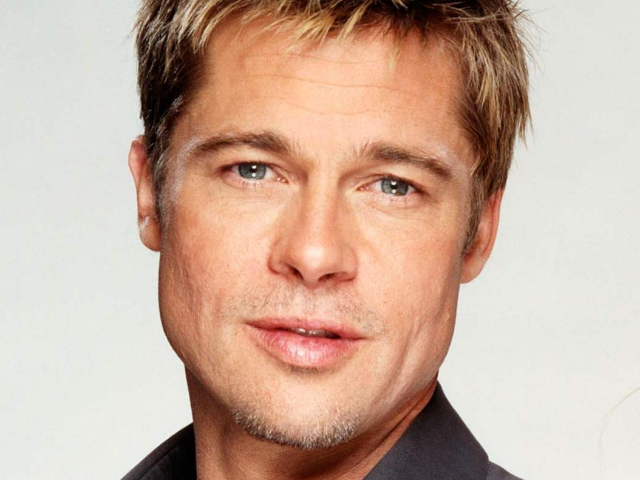

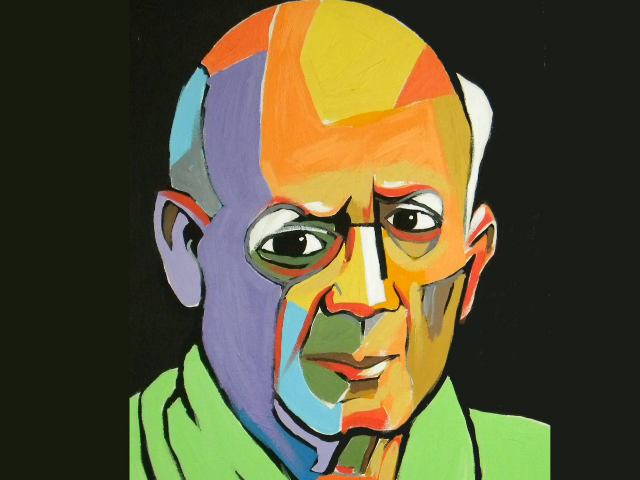

In [8]:
raw_photo, photo = prep_image(img0, 640, 480, bw=.8)
display_img_array(raw_photo, width=400)
raw_style, style = prep_image(img1, 640, 480, bw=.8)
display_img_array(raw_style, width=400)

In [9]:
rgbpca = PCA(n_components=3)
def show_layer(x):    
    s = x.shape
    x = x[0]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)  
    x = x.reshape((s[2]*s[3], s[1]))    
    x = rgbpca.fit_transform(x)
    print(x.shape, s)
    x = x.reshape((s[2], s[3], 3))      
    x = np.clip(x*255, 0, 255).astype('uint8')
    return x

In [10]:
photo.shape, style.shape

((1, 3, 480, 640), (1, 3, 480, 640))

(4800, 3) (1, 512, 60, 80)


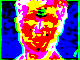

In [11]:
photo_feature = feature_output.eval({net_input:photo})
display_img_array(show_layer(photo_feature), width=200)

(4800, 3) (1, 512, 60, 80)


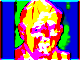

In [12]:
style_feature = feature_output.eval({net_input:style})
display_img_array(show_layer(style_feature), width=200)

In [13]:
C = style_feature.shape[1]
S = style.shape[3]//style_feature.shape[3]
PSIZE = (25//S)*2+1
print(S,C, PSIZE)

8 512 7


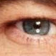

In [14]:
py, px =144//S,  220//S
display_img_array(raw_photo[py*S:(py+PSIZE)*S, px*S:(px+PSIZE)*S])

In [15]:
patch = photo_feature[:,:, py:py+PSIZE, px:px+PSIZE]

In [16]:
display_img_array(show_layer(patch), width=200)

(49, 3) (1, 512, 7, 7)


In [17]:
patch.shape

(1, 512, 7, 7)

In [18]:
def unwrap(a):
    return np.swapaxes(np.swapaxes(a[0],0,1),1,2)

In [19]:
# compute norm
input_img = T.tensor4()
layer_img = InputLayer((1, C, None, None), input_var=input_img)
layer_sqr_sum = ExpressionLayer(layer_img,  lambda x:T.sum(T.sqr(x), axis=1,keepdims=True) , output_shape=(1,1,None,None))
layer_norm = ConvLayer(layer_sqr_sum, 1, PSIZE, pad='valid', W=floatX(np.ones((1, 1, PSIZE,PSIZE))), b=None, nonlinearity=T.sqrt)
#layer_norm_reshape = ReshapeLayer(layer_norm, ([2], [3]))

In [20]:
# compute correlation
input_patch = T.tensor4()
layer_prod= ConvLayer(layer_img, 1, PSIZE, pad='valid', W=input_patch, b=None, nonlinearity=None)
layer_corr = ElemwiseMergeLayer([layer_prod, layer_norm], lambda a,b: a/b)
layer_corr_output = lasagne.layers.get_output(layer_corr)

In [21]:
# Pack into a function to find the Nearest Neighbor
best_match = theano.function([input_img, input_patch], T.max_and_argmax(layer_corr_output)+[T.shape(layer_corr_output)])

In [22]:
m, i, s = best_match(style_feature, patch)
y, x = np.unravel_index(i,s[2:])
print(m, s, (y,x))

74.39837646484375 [ 1  1 54 74] (27, 32)


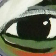

In [23]:
display_img_array(raw_style[y*S:(y+PSIZE)*S, x*S:(x+PSIZE)*S])

In [24]:
def mark_img(raw, y, x, color=[0,255,0]):
    disp = raw.copy()
    arr = disp[y*S:(y+PSIZE)*S,x*S:(x+PSIZE)*S]
    disp[y*S:(y+PSIZE)*S,x*S:(x+PSIZE)*S] = ((arr+np.array(color))/2).astype('uint8')
    return disp

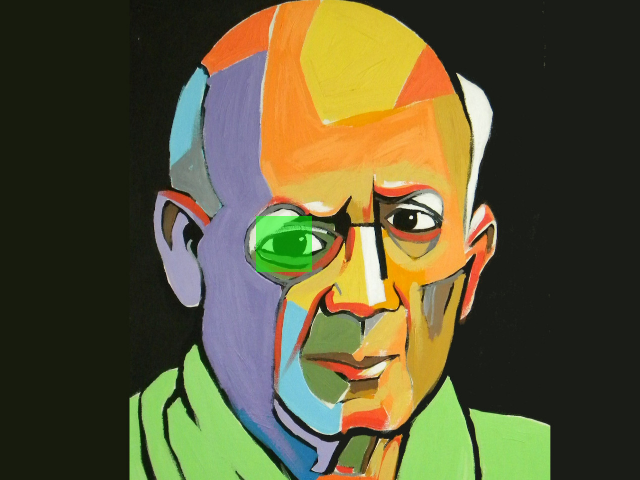

In [25]:
display_img_array(mark_img(raw_style,y,x))

103.83175659179688 [ 1  1 54 74] (22, 25)


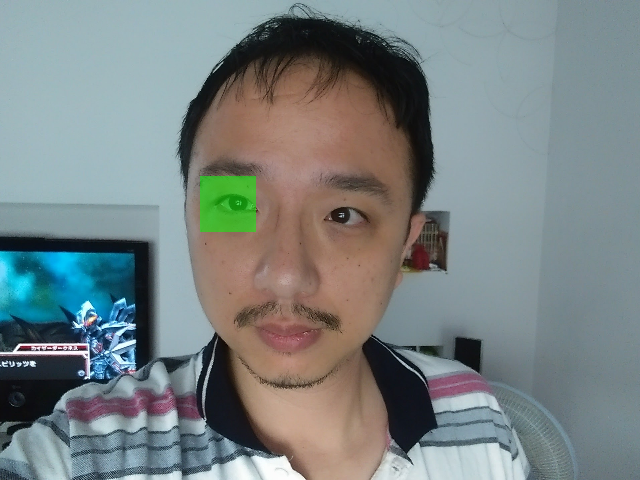

In [26]:

def demo_match(img1, patch):
    raw_style, style = prep_image(img1, 640, 480, bw=.8)
    style_feature = feature_output.eval({net_input:style})
    m, i, s = best_match(style_feature, patch)
    y, x = np.unravel_index(i,s[2:])
    print(m, s, (y,x))
    display_img_array(mark_img(raw_style, y,x))
img1 = imread("img/tjw1.jpg")
demo_match(img1, patch)

103.12097930908203 [ 1  1 54 74] (25, 25)


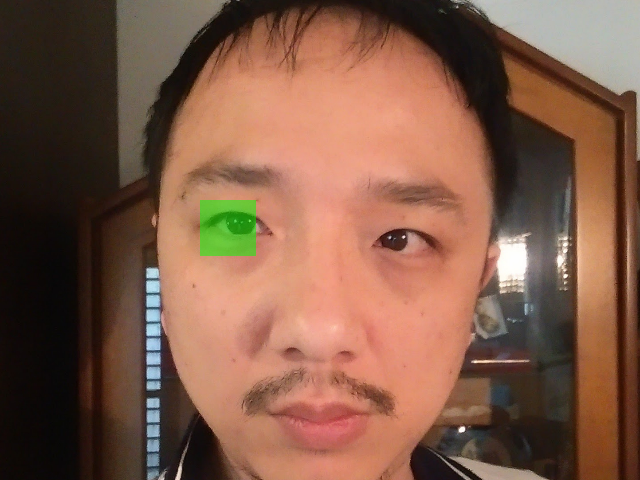

In [27]:
demo_match(imread("img/tjw2.jpg"), patch)

91.15653228759766 [ 1  1 54 74] (17, 39)


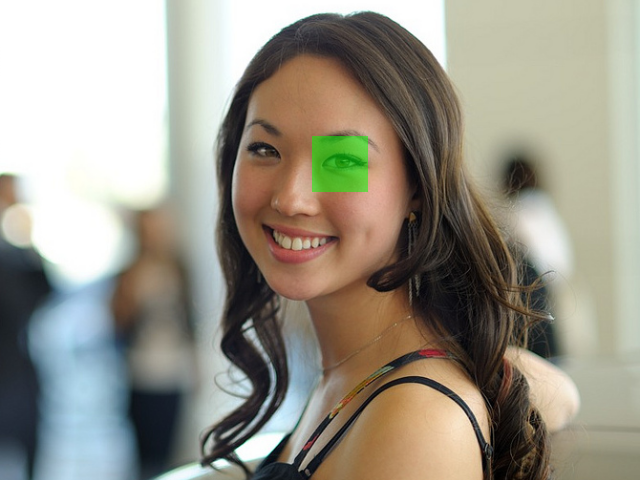

In [28]:
demo_match(imread("img/smile_face.jpg"), patch)

In [29]:
img0 = imread("img/smile_face.jpg")
img0 = img0[0:400, 200:800]
#display_img_array(img0)
raw_photo, photo = prep_image(img0, 640, 480, 1.)
photo_feature = feature_output.eval({net_input:photo})

img1 = imread("18500729_10.jpg")
raw_style, style = prep_image(img1, 640, 480)
style_conv4_1 = feature_output.eval({net_input:style})

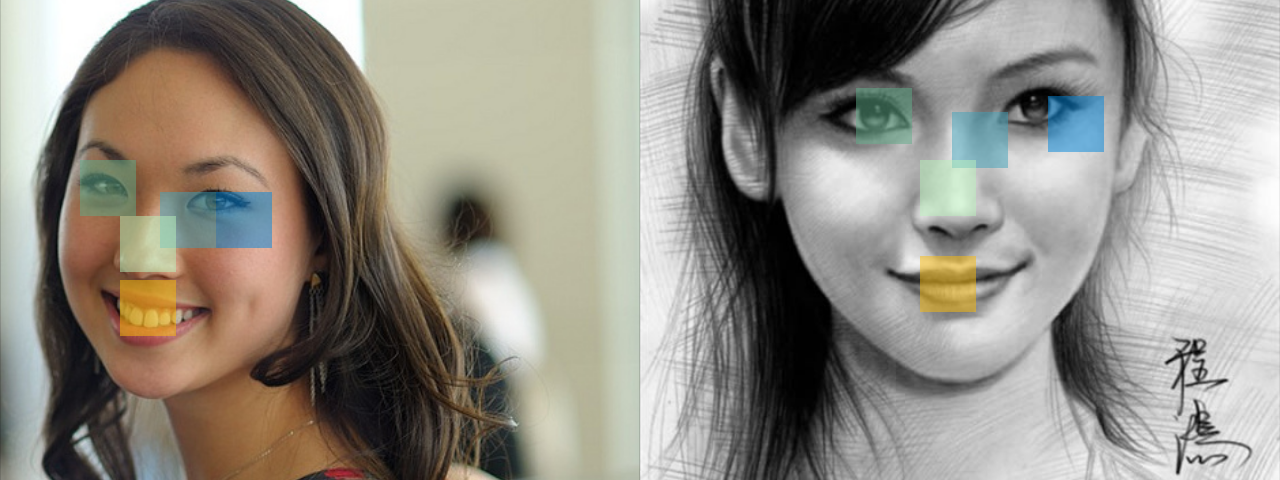

In [30]:
z0 = raw_photo
z1 = raw_style
from random import randint
patches = []
for py,px in [(160,80), (192,216), (192,160), (216,120),(280,120),]:
    py, px = py//S, px//S
    patch = photo_feature[:,:, py:py+PSIZE, px:px+PSIZE]
    m, i, s = best_match(style_conv4_1, patch)
    color=[randint(0,255), randint(0,255), randint(0,255)]
    z0 = mark_img(z0, py,px, color=color)    
    y, x = np.unravel_index(i,s[2:])    
    z1 = mark_img(z1, y,x, color=color)    
img = np.hstack([z0, z1])
display_img_array(img, width=800)